Model might be misspecified -- want to maximize where say, there are 1 or two more of the majority party. 

In [1627]:
using Revise
using Pkg; Pkg.activate(".")
using HypergraphModularity

using DataFrames
using CSV
using Clustering

using StatsBase

using Plots

using SpecialFunctions
using TSne
using Distances

 Activating environment at `~/hypergraph_modularities_code/Project.toml`


# Read the Data

In [1628]:
path = "data/congress-committees/senate_committees.csv"

function readCommittees(path)
    DF = DataFrame!(CSV.File(path));
    
    sub = combine(groupby(DF, :new_id)) do sdf
               sdf[argmax(sdf.new_id), :]
               end

    Z = sub[:, "party"];

    E = Dict()

    for sub ∈ groupby(DF, [:session, :committee])
        e = sub[!,:new_id]
        k = length(e)
        if !(k ∈ keys(E))
            E[k] = Dict()
        end
        E[k][e] = get(E[k], e, 0) + 1
    end

    for k in 1:maximum(keys(E))
        if !(k ∈ keys(E))
            E[k] = Dict()
        end
    end

    N = unique(DF[!, :new_id])

    H = hypergraph(N = N, E = E)

    HypergraphModularity.computeDegrees!(H);
    
    return H, Z
end

readCommittees (generic function with 1 method)

In [1629]:
H, Z = readCommittees(path)

H, Z = kcore(H, Z, 0)

(hypergraph
  N: Array{Int64}((337,)) [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  328, 329, 330, 331, 332, 333, 334, 335, 336, 337]
  E: Dict{Int64,Dict}
  D: Array{Int64}((337,)) [53, 14, 7, 12, 44, 42, 26, 46, 11, 34  …  6, 6, 3, 3, 4, 4, 2, 3, 3, 1]
, [1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  1, 2, 2, 1, 1, 2, 2, 1, 1, 1])

In [1630]:
for k in keys(H.E)
    if k > 25
        pop!(H.E, k, 0)
    end
end
HypergraphModularity.computeDegrees!(H)

H, Z = subHypergraph(H::hypergraph, H.D .> 0, Z)

(hypergraph
  N: Array{Int64}((337,)) [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  328, 329, 330, 331, 332, 333, 334, 335, 336, 337]
  E: Dict{Int64,Dict}
  D: Array{Int64}((337,)) [38, 14, 7, 12, 33, 42, 26, 45, 9, 34  …  6, 6, 3, 3, 4, 4, 2, 3, 3, 1]
, [1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  1, 2, 2, 1, 1, 2, 2, 1, 1, 1])

In [1631]:
mean(H.D)

15.181008902077151

# $\Omega$

Our idea here is that we want an $\Omega$ function that actively favors splits that are roughly even. 

In [1632]:
V = big(sum(H.D))

kmax = maximum(keys(H.E))

g(ℓ) = ℓ == 1 ? 1/100 : 1/ℓ^5

function ω(p, α)
    
    # x will be unity when the committees are split exactly evenly 
    k = sum(p)
    ℓ = length(p)
    
    δ = ℓ == 1 ? p[1] : p[1] - p[2]
    μ = k % 2 == 0 ? 2.0 : 1.0
    
    x = -μ + δ*log(μ) - logfactorial(δ)
    x = ℓ >= 1 ? exp(x) : 0.01
    
    return x/V^(α[k+kmax]*k)*g(ℓ)
#     return x^(α[k])/V^k
end

Ω = partitionIntensityFunction(ω, kmax);

α = vcat(repeat([10.0], kmax), repeat([2.0], kmax));

modularity(H, Z, Ω;α = α)

-88917.09982233566375952345649475579114094494062641625420804951324020567011188891

In [1633]:
ω([5, 5], α), Ω.ω([6, 4], α)

(2.803175842146650620518610471763972303238677359352671638404590614234314776885907e-77, 5.606351684293301241037220943527944606477354718705343276809181228468629553771815e-77)

In [1634]:
α = learnParameters(H, Z, Ω, α; max_iters = 10, verbose = true, tol = 1e-4);

Q = -42988.855246027335


In [1637]:
n = length(H.D)
Ẑ = SuperNodeLouvain(H, Ω; 
                     α = α, 
                     verbose = true, 
                     scan_order = "random", 
                     Z0 = collect(1:n))
#                      Z0 = rand([1, 2], length(H.D)));

Faster SuperNode Louvain: Phase 1
Louvain Iteration 1, Q = -45770.28
Louvain Iteration 2, Q = -44742.02
Louvain Iteration 3, Q = -44161.36
Louvain Iteration 4, Q = -43910.67
Louvain Iteration 5, Q = -43697.77
Louvain Iteration 6, Q = -43613.03
Louvain Iteration 7, Q = -43570.22
Louvain Iteration 8, Q = -43533.53
Louvain Iteration 9, Q = -43504.01
Louvain Iteration 10, Q = -43472.05
Louvain Iteration 11, Q = -43433.79
Louvain Iteration 12, Q = -43415.57
Louvain Iteration 13, Q = -43401.56
Louvain Iteration 14, Q = -43400.87
SuperNode Louvain: Phase 2
toc = 0.0014002323150634766
Louvain Iteration 1
Louvain Iteration 2
Louvain Iteration 3
t1 = 32.042065143585205
SuperNode Louvain: Phase 3
toc = 0.0011279582977294922
Louvain Iteration 1
t1 = 6.25963282585144


In [1636]:
[(Ẑ[e], Z[e]) for e in keys(H.E[10])]

11-element Array{Tuple{Array{Int64,1},Array{Int64,1}},1}:
 ([3, 1, 1, 1, 3, 3, 1, 3, 1, 3], [2, 2, 1, 1, 1, 1, 2, 2, 2, 2])
 ([1, 1, 1, 3, 3, 1, 2, 1, 1, 2], [1, 1, 2, 2, 1, 2, 1, 1, 1, 2])
 ([1, 1, 3, 1, 1, 3, 1, 1, 1, 1], [1, 1, 1, 2, 1, 2, 2, 2, 2, 2])
 ([1, 1, 3, 1, 1, 3, 1, 1, 1, 2], [1, 1, 2, 2, 2, 1, 1, 2, 2, 2])
 ([3, 1, 1, 3, 1, 3, 3, 3, 1, 2], [2, 2, 2, 1, 1, 2, 1, 1, 2, 2])
 ([1, 1, 3, 1, 1, 3, 1, 1, 1, 3], [1, 1, 1, 2, 1, 2, 2, 2, 2, 2])
 ([1, 2, 1, 2, 1, 1, 3, 1, 1, 1], [2, 1, 1, 2, 2, 1, 2, 2, 2, 1])
 ([1, 1, 1, 2, 1, 1, 3, 3, 1, 2], [1, 2, 2, 1, 1, 1, 1, 1, 2, 2])
 ([1, 3, 2, 1, 1, 3, 1, 1, 1, 3], [1, 2, 2, 2, 1, 2, 2, 2, 1, 1])
 ([1, 1, 1, 3, 3, 1, 3, 3, 3, 1], [2, 1, 1, 1, 1, 2, 2, 2, 2, 2])
 ([1, 1, 1, 3, 3, 1, 1, 2, 1, 1], [1, 1, 2, 2, 1, 2, 2, 1, 1, 1])

In [1517]:
Z̄ = copy(Z)
t = 0.1
for i in 1:length(Z)
    Z̄[i] = rand() < t ? 3-Z[i] : Z[i]
end
round(Float64(modularity(H, Z̄, Ω;α = α)), digits = 2), randindex(Z̄, Z)[1]

(-50731.95, 0.5712835835539724)

In [1518]:
Ẑ = SuperNodeLouvain(H, Ω; α = α, verbose = true, scan_order = "random", Z0 = Z̄);

Faster SuperNode Louvain: Phase 1
Louvain Iteration 1, Q = -50731.95
Louvain Iteration 2, Q = -50705.7
Louvain Iteration 3, Q = -50700.09
Louvain Iteration 4, Q = -50699.68
SuperNode Louvain: Phase 2
toc = 0.000843048095703125
Louvain Iteration 1
t1 = 1.4346771240234375


In [1521]:
# ok interesting, local  max is largely uncorrelated with true labels....
# that is a bummer =(. Does adding more edges help? 

round(Float64(modularity(H, Ẑ, Ω;α = α)), digits = 2), randindex(Ẑ, Z)[1]

(-50699.68, 0.47646858176251405)

In [1522]:
# true value

round(Float64(modularity(H, Z, Ω;α = α)), digits = 2), randindex(Z, Z)[1]

(-50547.82, 1.0)

In [1531]:
n_rounds = 200

Q = zeros(n_rounds)
ARI = zeros(n_rounds)

for i ∈ 1:n_rounds
    Z̄ = copy(Z)
    t = 0.1*rand()
    for j ∈ 1:length(Z)
        Z̄[j] = rand() < t ? 3-Z[j] : Z[j]
    end
    Q[i] = modularity(H, Z̄, Ω;α = α)
    ARI[i] = randindex(Z, Z̄)[1]
end

In [1532]:
using RCall

R"""
library(tidyverse)
"""

RObject{StrSxp}
 [1] "forcats"   "stringr"   "dplyr"     "purrr"     "readr"     "tidyr"    
 [7] "tibble"    "ggplot2"   "tidyverse" "stats"     "graphics"  "grDevices"
[13] "utils"     "datasets"  "methods"   "base"     


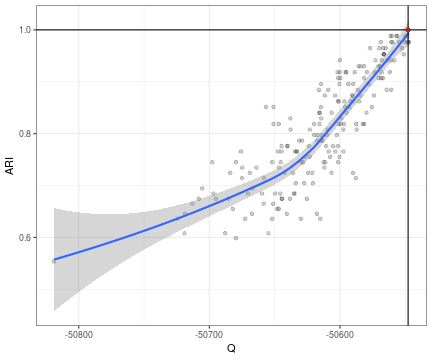

RObject{VecSxp}


┌ Warning: RCall.jl: `geom_smooth()` using method = 'loess' and formula 'y ~ x'
└ @ RCall /home/phil/.julia/packages/RCall/Qzssx/src/io.jl:160


In [1533]:
R"""
df <- tibble(Q = $Q, ARI = $(ARI))

best_df <- tibble(Q = $(modularity(H, Z, Ω; α =α)), ARI = $(randindex(Z, Z)[1]))

df %>% 
    ggplot() + 
    aes(x = Q, y = ARI) + 
    geom_point(alpha = 0.2) + 
#    xlim(max(df$Q) - 5, max(best_df$Q)) + 
    geom_smooth() + 
    geom_hline(aes(yintercept = 1)) + 
    geom_vline(aes(xintercept = best_df$Q[1])) + 
    geom_point(data = best_df, color = "firebrick") + 
    theme_bw()
"""

# Synthetic

Can we do this when we have a fake hypergraph?

In [1183]:
n = 100

kmax = 4

Z = rand(1:2, n)

function ω(p, α)
    k = sum(p)
    x = 4*prod(p) / k^2
    return 0.5*x^5/n^(α[k+kmax]*k)*k^9
end

Ω = partitionIntensityFunction(ω, kmax);

α = vcat(repeat([10.0], kmax), repeat([.1], kmax));

ϑ =  1000000000*dropdims(ones(1,n) + rand(1,n), dims = 1)

H = sampleSBM(Z, ϑ, Ω;α=α0, kmax=kmax, kmin = 1)

hypergraph
  N: Array{Int64}((100,)) [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  91, 92, 93, 94, 95, 96, 97, 98, 99, 100]
  E: Dict{Int64,Dict}
  D: Array{Int64}((100,)) [9, 7, 7, 3, 13, 5, 6, 4, 5, 3  …  7, 8, 6, 1, 9, 12, 7, 6, 2, 2]


In [1184]:
mean(H.D)

5.77

In [1185]:
[length(H.E[k]) for k in 1:maximum(keys(H.E))]

4-element Array{Int64,1}:
  55
 100
  54
  40

In [1186]:
α = learnParameters(H, Z, Ω, α; max_iters = 10, verbose = true, tol = 1e-4);
round(modularity(H, Z, Ω;α = α)), randindex(Z, Z)[1]

Q = -2878.0809048283973


(-2878.0, 1.0)

In [1211]:
Z̄ = copy(Z)
t = 0.1
for i in 1:length(Z)
    Z̄[i] = rand() < t ? 3-Z[i] : Z[i]
end
round(modularity(H, Z̄, Ω;α = α)), randindex(Z̄, Z)[1]

(-2954.0, 0.6044056963032804)

In [1212]:
Ẑ = SuperNodeLouvain(H, Ω; α = α, verbose = false, scan_order = "random", Z0 = Z̄);

In [1213]:
# ok interesting, local  max is largely uncorrelated with true labels....
# that is a bummer =(. Does adding more edges help? 

round(Float64(modularity(H, Ẑ, Ω;α = α)), digits = 2), randindex(Ẑ, Z)[1]

(-2876.4, 0.6363294399767251)

In [1545]:
Pkg.add("Distances")

  Resolving package versions...
   Updating `~/hypergraph_modularities_code/Project.toml`
  [b4f34e82] + Distances v0.9.0
   Updating `~/hypergraph_modularities_code/Manifest.toml`
 [no changes]
